# Figures From: Conjugacy, consistency and variational inference in RPM

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ast import literal_eval

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from rpfa import RPM
from data import RPMData
import torch.nn.functional as F
from utils_demo import rearrange_mnist


## Load Preprocessed Datasets

In [2]:

# DataFrames
dfs = {
    'FA': pd.read_csv('./data/flexible_study_1.cvs'),
    #'MNIST': pd.read_csv('./data/flexible_study_2.cvs'),
}

# Float losses
for key in dfs.keys():
    dfs[key]['loss'] = dfs[key]['loss'].apply(lambda x: literal_eval(x))

# Experiments to plot
N_plot = {
    'FA': [10, 100, 1000],
    #'MNIST': [100, 1000, 3000],
}

# Color Map
colors = {
    'flexible': 'C0',
    'constrained_prior': 'C2',
    'semi_flexible': 'C1',
}

# Order
modes = list(colors.keys())

## Plots

C:\Users\marce\AppData\Local\Temp\ipykernel_15780\3639928684.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['relative_loss'] = gdp
C:\Users\marce\AppData\Local\Temp\ipykernel_15780\3639928684.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['relative_loss'] = gdp
C:\Users\marce\AppData\Local\Temp\ipykernel_15780\3639928684.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

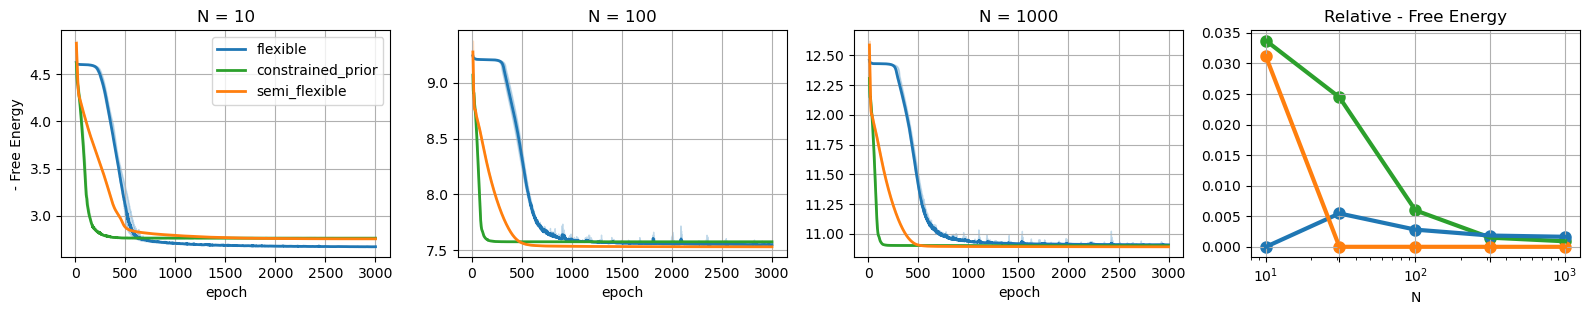

In [3]:
# Loop over experiments

no_label = False
for key in dfs.keys():
    df = dfs[key]

    # Small hack to solve otation incosistency
    if not 'num' in df:
        df['num'] = df['nums']

    # Grasp Final Loss
    df['last_loss'] = df['loss'].apply(lambda x: np.quantile(x[-500:], 0.5))

    # Group by method and sample size
    grouped = df.groupby(['mode', 'num']).quantile(0.5, numeric_only=True).reset_index()
    summary = pd.DataFrame([])
    for num in grouped.num.unique():
        gdf = grouped[grouped.num == num]
        gdp = (gdf.last_loss - gdf.last_loss.min()) / gdf.last_loss.min()
        gdf['relative_loss'] = gdp    
        summary = pd.concat([summary, gdf])



    # Figures
    width = len(N_plot[key]) + 1
    heigh = 1
    plt.figure(figsize=(4 * width, 3.25 * heigh))
    
    for mm, mode in enumerate(modes):
        for nn, num in enumerate(N_plot[key]):
    
            # Current mask and mode
            mask = (df['mode'] == mode).values *  (df['num'] == num).values
            dfc = df[mask]
    
            # - Free Energy
            losses = np.stack(dfc['loss'].values, axis=0)

            # Remove first few iterations (for visualization)
            epoch_offset = 10

            # Median and intervals
            ll = losses[:, epoch_offset:]
            mm = np.quantile(ll, 0.5, axis=0)
            lo = np.quantile(ll, 0.25, axis=0)
            up = np.quantile(ll, 0.75, axis=0)
            xx = epoch_offset + np.arange(ll.shape[-1])

            # Plots
            plt.subplot(heigh, width, nn + 1)
            plt.fill_between(xx, lo, up, color=colors[mode], alpha=.25)
            plt.plot(xx, mm, c=colors[mode], alpha = 1.0, label = mode, lw = 2)
            plt.grid('on')
            
            if not no_label:
                plt.xlabel('epoch')
                # Labels
                if nn == 0:
                    plt.ylabel('- Free Energy')
                    plt.legend()
                plt.title('N = ' + str(num))
            
    plt.tight_layout()
    

    # Plot summary
    ax = plt.subplot(heigh, width, nn + 2)
    for mode in summary['mode'].unique():
        ll = summary[summary['mode'] == mode].relative_loss.values
        num = summary[summary['mode'] == mode].num.values
        plt.plot(num, ll, color = colors[mode], label=mode, lw=3)
        plt.scatter(num, ll, color = colors[mode], lw=3)
    if not no_label:
        plt.xlabel('N')
        plt.title('Relative - Free Energy')
    plt.grid('on')
    ax.set_xscale('log')
    plt.tight_layout()
    plt.xticks(ticks=num)
    
    title = './data/rpm_convergence_' + key
    if no_label:
        title += '_no_label'
    plt.savefig(title + '.pdf')


## Plot prior